In [1]:
import time
start_notebook_time = time.time()

In [2]:
import sklearn.linear_model
from sklearn.datasets import fetch_openml
import sys
import numpy as np
# np.set_printoptions(threshold=sys.maxsize)

In [3]:
mnist = fetch_openml('mnist_784', version=1)

/Users/zivlazarov/miniforge3/envs/tensorflow-env/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
# setting pixel values to be in [0, 1] range
# X = X/255.0

In [7]:
X.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# getting the correct shape
X.shape

(70000, 784)

In [9]:
y.shape

(70000,)

In [10]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [11]:
# working with integers instead of strings for convenience
y = y.apply(lambda x : int(x))

In [12]:
y.head()

0    5
1    0
2    4
3    1
4    9
Name: class, dtype: category
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]

In [13]:
X, y = X.to_numpy(), y.to_numpy()

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

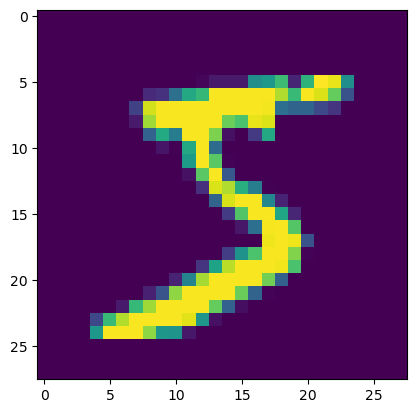

In [15]:
# getting an idea of an image
plt.imshow(X[0, :].reshape(28, 28))

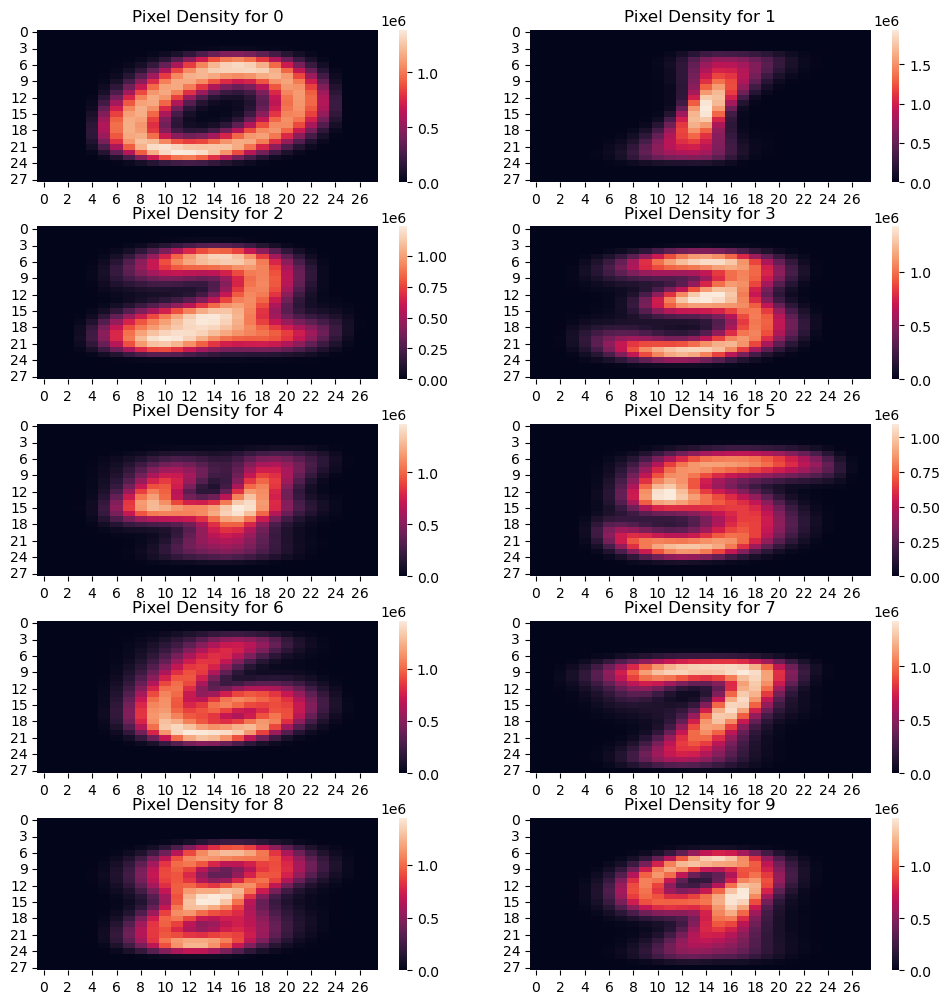

In [16]:
# showing pixel density for every digit in a form of the digit itself
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
fig.tight_layout()
for i in range(len(np.unique(y))):
    # not taking the bias column into consideration
    digit_i_samples = X[np.where(y == i)][:, :]
    # reshaping all digit samples to the original matrices they were and adding them together to get the heatmap
    sns.heatmap(np.sum(digit_i_samples.reshape(len(digit_i_samples), 28, 28), axis=0), ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f'Pixel Density for {i}')

In [17]:
### NOTE ###
# we can see from the above heatmap that the densiest pixels for 3 and 8 are similar
# the same can be said for 4 and 9

(array([6903., 7877., 6990., 7141., 6824., 6313., 6876., 7293., 6825.,
        6958.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

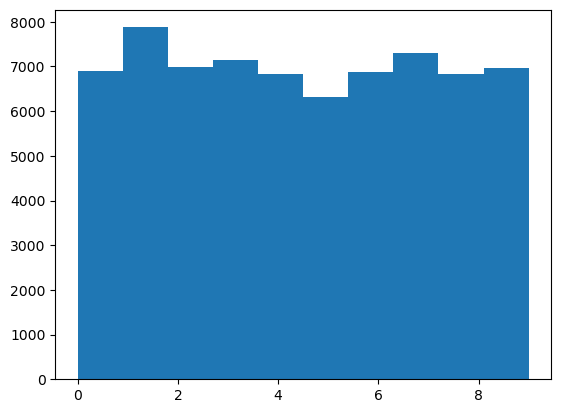

In [18]:
# check distribution of each digit
plt.hist(y)

In [19]:
# adding the bias column as the first column
X = np.concatenate((np.ones(shape=(X.shape[0],))[:, np.newaxis], X), axis=1)

In [20]:
np.unique(X[:, 0])

array([1.])

In [21]:
X.shape

(70000, 785)

In [22]:
class Perceptron:

    def __init__(self, num_features, classes, epochs=1):
        # num_features includes the extra bias column with the dataset so we'll add it
        self.num_features = num_features
        # values of the multi-class labels
        self.classes = classes
        self.num_classes = len(self.classes)
        self.num_samples = 0
        self.epochs = epochs

        # initializing the weights vectors for every class with values [-1, 1]
        self.weights = np.random.uniform(low=-1, high=1, size=(self.num_classes, self.num_features))
        # weight vectors for pocketing
        self.final_weights = None
        # determined by the size of samples
        self.labels = None
        # training errors of the multi class perceptron
        self.train_errors = None
        # calculate every visualization_iteration_skip-th sample
        self.visualization_iteration_skip = 10

    def init_multi_class_labels(self, y_train, negative_value=-1):
        self.num_samples = y_train.shape[0]
        # initializing the perceptron training labels
        self.labels = np.ones(shape=(self.num_classes, self.num_samples))
        # setting labels' values based on every class in the training data
        for class_idx in range(self.num_classes):
            self.labels[class_idx, np.where(y_train != class_idx)[0]] = negative_value

        self.train_errors = np.full(shape=self.num_samples // self.visualization_iteration_skip, fill_value=np.inf)

    def fit(self, X_train, y_train, visualize=True):
        self.init_multi_class_labels(y_train)
        # defining error value for each class for pocket algorithm
        min_errors = np.full(shape=(self.num_classes,), fill_value=np.inf)
        random_samples_pct = 0.16
        '''
        choosing 16% (arbitrary decision) of the dataset as random samples to calculate errors,
        as we can see from the above cells, the number of occurrences of each digit is 
        distributed almost uniformly, so getting 16% of the samples can distribute the amount of each
        digit in the random sample almost evenly for more general optimization
        '''
        num_random_samples = int(random_samples_pct * self.num_samples)
        # initializing the final_weights here for easier usage with inheritance
        self.final_weights = np.copy(self.weights)
        # error values for every 10th iteration (/sample) for the visualization
        iterations_errors = np.full(shape=(self.num_samples // self.visualization_iteration_skip, self.num_classes),
                                    fill_value=np.inf)
        # traversing the dataset (per sample approach)
        for epoch in range(self.epochs):
            for t in range(self.num_samples):
                # predicting the current sample with every weight vector using the np.sign method
                # because probability of the dot product to be exactly 0 is very low, and if so, we'll count predictions on the hyperplane
                # to be negative
                y_preds = np.sign(self.weights.dot(X_train[t]))

                # dividing classes based on their predictions
                misclassified_classes_indexes = np.where(y_preds != self.labels[:, t])
                # correcting misclassified weight vectors by multiplying the true sign value by the current sample for each weight vector
                self.weights[misclassified_classes_indexes] += \
                    self.labels[misclassified_classes_indexes, t][0][:, np.newaxis] * X_train[t, :]

                # pocketing every visualization_iteration_skip samples
                if t % self.visualization_iteration_skip == 0:
                    # getting random indexes for the sampling
                    random_samples_indexes = np.random.choice(self.num_samples, num_random_samples)

                    # calculating the errors from the random samples based on the improved vectors
                    y_preds_unsigned = self.weights.dot(X_train[random_samples_indexes, :].T)
                    # errors for the binary perceptrons
                    errors_t = np.sum(
                        np.sign(y_preds_unsigned) != self.labels[:, random_samples_indexes],
                        axis=1) / num_random_samples
                    # error for the multi class perceptron
                    model_error = np.sum(self.classes[np.argmax(y_preds_unsigned.T, axis=1)] != y_train[random_samples_indexes]) \
                        / num_random_samples

                    if visualize:
                        iterations_errors[t // self.visualization_iteration_skip] = np.copy(errors_t)
                        self.train_errors[t // self.visualization_iteration_skip] = model_error

                    # pocketing the improved weight vectors and updating the min errors
                    to_improve_classes_indexes = np.where(errors_t < min_errors)[0]

                    self.final_weights[to_improve_classes_indexes] = \
                        np.copy(self.weights[to_improve_classes_indexes])

                    min_errors[to_improve_classes_indexes] = errors_t[to_improve_classes_indexes]

        print(f'Errors after training (per class):\n{min_errors}')
        
        # visualizing the errors for each class
        if visualize:
            fig, ax = plt.subplots(self.num_classes // 2, 2, figsize=(10, 10))
            fig.suptitle('Single Class Loss')
            # for better visibility
            fig.tight_layout()
            # for matching the visualization_iteration_skip variable to the sample number
            x_axis = [epoch * self.visualization_iteration_skip for epoch in range(iterations_errors.shape[0])]
            for i in range(iterations_errors.shape[1]):
                ax[i // 2, i % 2].plot(x_axis, iterations_errors[:, i])
                ax[i // 2, i % 2].set_title(f'Error for class {i}')
            # setting the max value of the y axis to be 0.5 for better readability
            plt.setp(ax, xlim=(0, self.num_samples), ylim=(0, 1))
            plt.show()

        # setting the trained weight vectors
        self.weights = np.copy(self.final_weights)

    def predict(self, X_test):
        return np.argmax(X_test @ self.weights.T, axis=1)

In [23]:
from sklearn.model_selection import train_test_split
num_train_samples = 60000

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=num_train_samples/len(X), shuffle=True)

In [25]:
X_train.shape

(60000, 785)

In [26]:
perceptron = Perceptron(num_features=X_train.shape[1], classes=np.unique(y))

Errors after training (per class):
[0.00697917 0.00541667 0.0190625  0.02395833 0.01541667 0.02552083
 0.01177083 0.01364583 0.0528125  0.03791667]


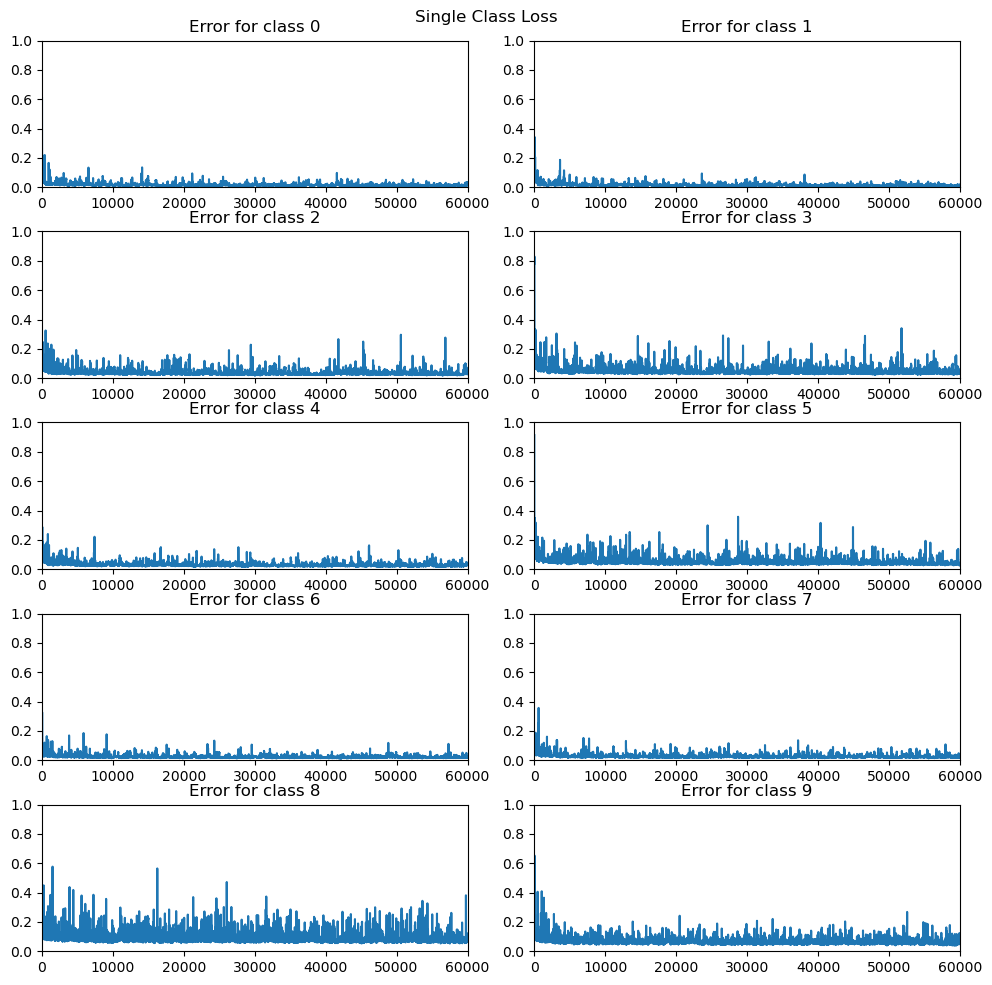

CPU times: user 5min 17s, sys: 20.3 s, total: 5min 37s
Wall time: 1min 41s


In [27]:
%%time
perceptron.fit(X_train, y_train)

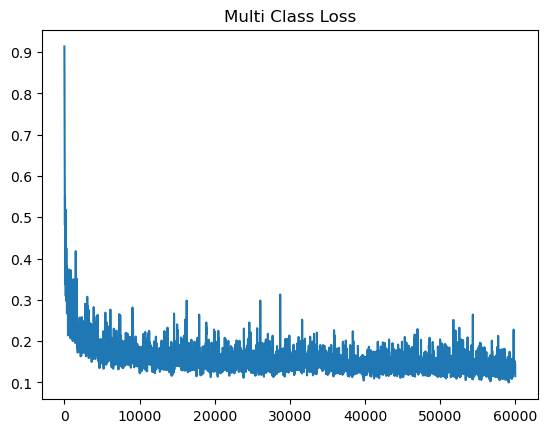

In [28]:
x_axis = [epoch * perceptron.visualization_iteration_skip for epoch in range(perceptron.train_errors.shape[0])]
plt.title('Multi Class Loss')
plt.plot(x_axis, perceptron.train_errors)
plt.show()

In [29]:
def accuracy(predictions, y_test):
    return np.sum(predictions == y_test) / len(y_test)


def metrics(class_idx, X_test, y_test, model):
    if class_idx == -1:
        predictions = model.predict(X_test)
        confusion_matrix = np.zeros(shape=(model.num_classes, model.num_classes))
        # calculating the confusion matrix
        for idx in range(len(y_test)):
            y_test_idx = y_test[idx]
            preds_idx = predictions[idx]
            confusion_matrix[y_test_idx, preds_idx] += 1

        model_accuracy = accuracy(predictions, y_test)

        return confusion_matrix, model_accuracy

    else:
        class_sign_y = np.ones(shape=(len(y_test),))
        class_sign_y[np.where(y_test != model.classes[class_idx])] = -1

        predictions = np.sign(X_test.dot(model.weights[class_idx]))

        # predicted class_idx correctly
        tp = len(class_sign_y[(class_sign_y == predictions) & (class_sign_y == 1)])
        # predicted not class_idx correctly
        tn = len(class_sign_y[(class_sign_y == predictions) & (class_sign_y == -1)])
        # predicted class_idx incorrectly
        fp = len(class_sign_y[(class_sign_y != predictions) & (class_sign_y == -1)])
        # predicted not class_idx incorrectly
        fn = len(class_sign_y[(class_sign_y != predictions) & (class_sign_y == 1)])

        model_accuracy = (tp + tn) / len(y_test)
        sensitivity = tp / (tp + fn)
        selectivity = tn / (tn + fp)

        confusion_matrix = np.zeros(shape=(2, 2))
        confusion_matrix[0, 0] = tp
        confusion_matrix[0, 1] = fn
        confusion_matrix[1, 0] = fp
        confusion_matrix[1, 1] = tn

        return confusion_matrix, model_accuracy, sensitivity, selectivity

In [30]:
def visualize_metrics(class_idx, X_test, y_test, model):
    if class_idx == -1:
        predictions = model.predict(X_test)
        confusion_matrix, accuracy = metrics(-1, X_test, y_test, model)
        # displaying the confusion matrix with a heatmap
        sns.heatmap(confusion_matrix, annot=True, fmt='.4g')
        plt.ylabel('Y True')
        plt.xlabel('Y Pred')
        plt.title(
            f'Multi Class Perceptron Confusion Matrix\nAccuracy: {round(np.sum(predictions == y_test) / len(y_test), 3)}')
    else:
        # creating the grid for the classes
        fig, ax = plt.subplots(model.num_classes // 2, 2, figsize=(10, 10), constrained_layout=True)
        # fig.tight_layout()
        for i in range(model.num_classes):
            confusion_matrix, accuracy, sensitivity, selectivity = metrics(i, X_test, y_test, model)

            sns.heatmap(confusion_matrix, ax=ax[i // 2, i % 2], annot=True, fmt='.4g')
            ax[i // 2, i % 2].set_title(f'Confusion Matrix for Class {model.classes[i]}\n' + \
                                        f'Acc: {round(accuracy, 3)} | Sen: {round(sensitivity, 3)} | Sel: {round(selectivity, 3)}')
            ax[i // 2, i % 2].set_ylabel('Y True')
            ax[i // 2, i % 2].set_xlabel('Y Pred')
    plt.show()

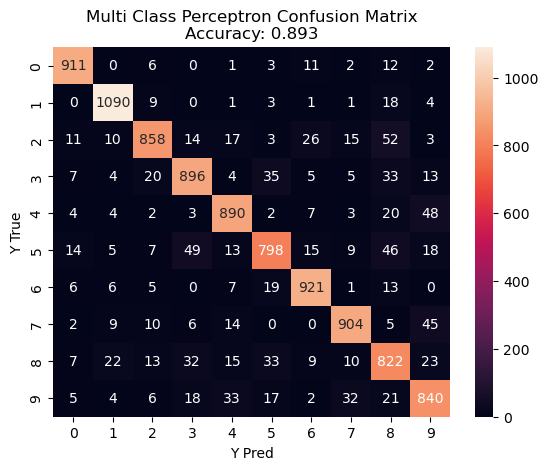

In [31]:
visualize_metrics(-1, X_test, y_test, perceptron)

In [32]:
'''
In respect to the multi class perceptron, we can see from the loss functions during training that 0,1,4,6,7 digits are more stable in terms
of the loss values, and, in a way, their loss values are converging towards 0, which the other digits are more noisy and are less
confident during training.
Additionaly, we can see from the multi class confusion matrix that the digit 8 is negatively predicted as 3 or 5 and the same applies
for 4 and 9. This is kind of expected as those groups of digits are written in a similar way, and have a similar shape.
My assumption is that more strong pixel values in the samples are affecting this scenario, as 2,3,5,8,9 are digits which require more
pixels to show, so the "fixing" of the weights during training is more drastic.
'''

'\nIn respect to the multi class perceptron, we can see from the loss functions during training that 0,1,4,6,7 digits are more stable in terms\nof the loss values, and, in a way, their loss values are converging towards 0, which the other digits are more noisy and are less\nconfident during training.\nAdditionaly, we can see from the multi class confusion matrix that the digit 8 is negatively predicted as 3 or 5 and the same applies\nfor 4 and 9. This is kind of expected as those groups of digits are written in a similar way, and have a similar shape.\nMy assumption is that more strong pixel values in the samples are affecting this scenario, as 2,3,5,8,9 are digits which require more\npixels to show, so the "fixing" of the weights during training is more drastic.\n'

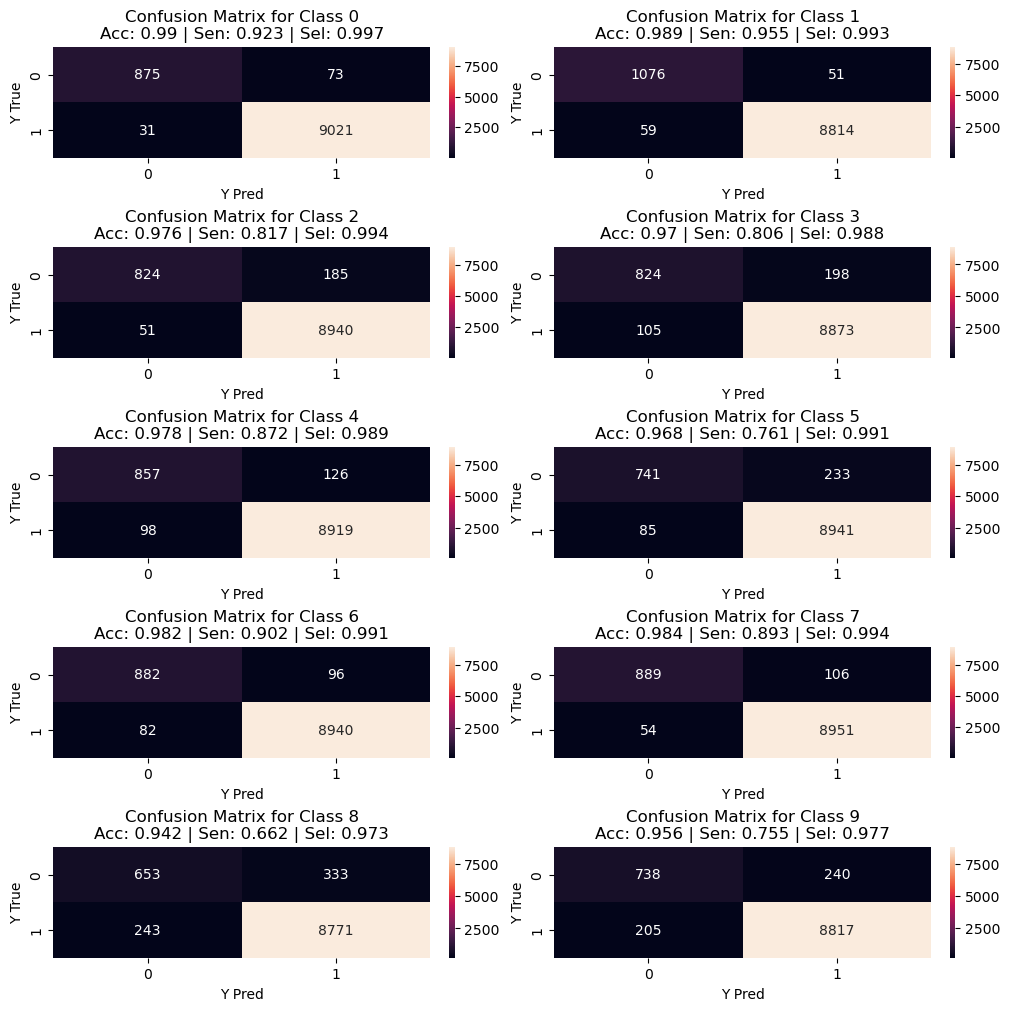

In [33]:
visualize_metrics(0, X_test, y_test, perceptron)

In [34]:
'''
We can see from the metrics that out selectivity for each digit is very high, and our sensitivity is a little lower, which means our binary
classifiers are not classifying false positives in large quantities, and some are classifying false negatives more than they "should".
This gives us more confidence in the classifiers for not predicting positively incorrectly, but they will predict more negatives in such
matter.
In terms of accuracy, the binary classifiers are very accurate.
'''

'\nWe can see from the metrics that out selectivity for each digit is very high, and our sensitivity is a little lower, which means our binary\nclassifiers are not classifying false positives in large quantities, and some are classifying false negatives more than they "should".\nThis gives us more confidence in the classifiers for not predicting positively incorrectly, but they will predict more negatives in such\nmatter.\nIn terms of accuracy, the binary classifiers are very accurate.\n'

In [35]:
'''
To summarize, for the training itself, I went for the more efficient-focused implementation, using the fact that the digits in the 
dataset are distributed almost uniformly which makes it easy for us to random-sample the training data to calculate our loss function with
confidence as we can assume the samples will also distribute in a similar fashion during the calculation. This approach led me to calculate
the loss function and pocket the relevant weights vectors accordingly every 10 iterations to save valuable time and resources during
training without sacrificing the correctness of the algorithm.
'''

'\nTo summarize, for the training itself, I went for the more efficient-focused implementation, using the fact that the digits in the \ndataset are distributed almost uniformly which makes it easy for us to random-sample the training data to calculate our loss function with\nconfidence as we can assume the samples will also distribute in a similar fashion during the calculation. This approach led me to calculate\nthe loss function and pocket the relevant weights vectors accordingly every 10 iterations to save valuable time and resources during\ntraining without sacrificing the correctness of the algorithm.\n'

In [36]:
time.time() - start_notebook_time

129.79451704025269